In [28]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

import os



### First check the correct hsv value of lane marks 

In [29]:
# load any sample image:
image = cv2.imread('./images/frame0185.jpg') #0134, 0078, 0041, 0051, 0055, 0062,  0006, 0058, 0070, 0154, 0164, 0168, 185, 0018
hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

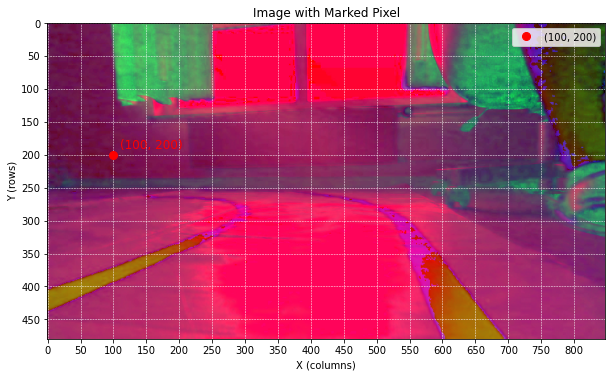

In [30]:
def show_with_grid_and_marker(img, x, y, title=""):
    plt.figure(figsize=(10, 6))
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title(title)
    plt.xlabel("X (columns)")
    plt.ylabel("Y (rows)")
    
    # Draw a red dot at (x, y)
    plt.plot(x, y, 'ro', markersize=8, label=f'({x}, {y})')
    
    # Optionally, annotate the point
    plt.text(x + 10, y - 10, f'({x}, {y})', color='red', fontsize=12)

    # Grid settings
    plt.grid(True, color='white', linestyle='--', linewidth=0.5)
    plt.xticks(np.arange(0, img.shape[1], step=50))
    plt.yticks(np.arange(0, img.shape[0], step=50))
    
    plt.legend()
    plt.show()
    
x, y = 100, 200
show_with_grid_and_marker(hsv, x, y, "Image with Marked Pixel")

In [31]:
# Selecte desired pixel cords manually
# --- Define Points ---
white_coords = [(400,300)]
yellow_coords = [(650,450), (600,400), (50,400), (150,352), (552,350)]


🎨 Yellow Pixel HSV Values:
  1. (650, 450) → H:6, S:113, V:170
  2. (600, 400) → H:4, S:56, V:196
  3. (50, 400) → H:10, S:125, V:163
  4. (150, 352) → H:4, S:48, V:155
  5. (552, 350) → H:170, S:13, V:227

🎨 White Pixel HSV Values:
  1. (400, 300) → H:84, S:5, V:255


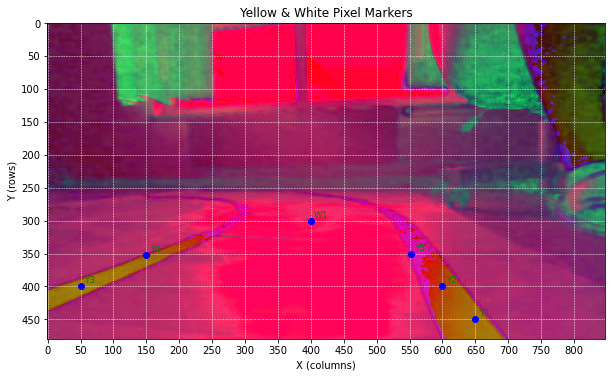

In [32]:

# --- Helper Function ---
def show_with_markers(img_bgr, points, title="Image with Markers"):
    plt.figure(figsize=(10, 6))
    plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
    for (x, y), label in points:
        plt.plot(x, y, 'bo')  # red dot
        plt.text(x + 5, y - 5, label, color='green', fontsize=9)
    plt.title(title)
    plt.grid(True, color='white', linestyle='--', linewidth=0.5)
    plt.xlabel("X (columns)")
    plt.ylabel("Y (rows)")
    plt.xticks(np.arange(0, img_bgr.shape[1], step=50))
    plt.yticks(np.arange(0, img_bgr.shape[0], step=50))
    plt.show()

# --- Load image and convert to HSV ---
#frame = cv2.imread('frame_00177.jpg')
#hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
# --- Sample HSV values ---
print("🎨 Yellow Pixel HSV Values:")
for i, (x, y) in enumerate(yellow_coords, 1):
    h, s, v = hsv[y, x]
    print(f"  {i}. ({x}, {y}) → H:{h}, S:{s}, V:{v}")

print("\n🎨 White Pixel HSV Values:")
for i, (x, y) in enumerate(white_coords, 1):
    h, s, v = hsv[y, x]
    print(f"  {i}. ({x}, {y}) → H:{h}, S:{s}, V:{v}")

# --- (Optional) Show markers on image ---
all_points = [(pt, f"Y{i+1}") for i, pt in enumerate(yellow_coords)] + \
             [(pt, f"W{i+1}") for i, pt in enumerate(white_coords)]
show_with_markers(hsv, all_points, title="Yellow & White Pixel Markers")

### Update these based in extract_yellow_lane_mask() funtion
    lower_yellow = np.array([3, 70, 100])
    upper_yellow = np.array([15, 180, 200])

In [33]:

# --- Utility display function ---
def display_image(image, title="Image", cmap=None):
    plt.figure(figsize=(10, 6))
    if cmap:
        plt.imshow(image, cmap=cmap)
    else:
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title(title)
    plt.axis('off')
    plt.show()

# --- Step 1: Load image from folder ---
def load_image(frame_id, folder):
    filename = os.path.join(folder, f"frame{frame_id}.jpg")  # or .jpg
    if not os.path.exists(filename):
        print(f"Image not found: {filename}")
        return None
    img = cv2.imread(filename)
    if img is None:
        print(f"Failed to read image: {filename}")
    return img

# --- Step 2: Define ROI mask ---
def get_roi_mask(shape):
    h, w = shape[:2]
    mask = np.zeros((h, w), dtype=np.uint8)
    pts = np.array([[
        (int(0 * w), h), (int(0.99 * w), h),
        (int(0.9 * w), int(0.6 * h)),
        (int(0.2 * w), int(0.6 * h))
    ]], dtype=np.int32)
    cv2.fillPoly(mask, pts, 255)
    return mask

# --- Step 3: Extract yellow lane mask ---
def extract_yellow_lane_mask(image):
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    lower_yellow = np.array([3, 70, 100])
    upper_yellow = np.array([15, 180, 200])
    mask = cv2.inRange(hsv, lower_yellow, upper_yellow)
    kernel = np.ones((3, 3), np.uint8)
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
    return mask

# --- Step 4: Find lane points in a horizontal band ---
def find_lane_points(mask, y_start_ratio=0.77, y_end_ratio=0.85):
    h, w = mask.shape
    start_y = int(y_start_ratio * h)
    end_y = int(y_end_ratio * h)
    row_band = mask[start_y:end_y, :]
    ys, xs = np.where(row_band > 0)
    ys += start_y
    return xs, ys, start_y, end_y

# --- Step 5: Draw lane points and region rectangle ---
def draw_lane_points(image, xs, ys, start_y, end_y):
    img_out = image.copy()
    # Draw rectangle for lane detection band
    cv2.rectangle(img_out, (0, start_y), (img_out.shape[1], end_y), (255, 0, 0), 1)
    # Draw detected points as small circles
    for x, y in zip(xs, ys):
        cv2.circle(img_out, (x, y), 1, (0, 255, 255), -1)
    return img_out

# --- Step 6: Simple lane centers from points ---
def simple_lane_centers(xs, ys):
    if len(xs) == 0:
        return []
    mid_x = np.median(xs)
    left_points = [(x, y) for x, y in zip(xs, ys) if x < mid_x]
    right_points = [(x, y) for x, y in zip(xs, ys) if x >= mid_x]
    centers = []
    if left_points:
        lx, ly = zip(*left_points)
        centers.append((int(np.mean(lx)), int(np.mean(ly))))
    if right_points:
        rx, ry = zip(*right_points)
        centers.append((int(np.mean(rx)), int(np.mean(ry))))
    return centers
#---k-mean--

from sklearn.cluster import KMeans

def kmeans_lane_centers(xs, ys, n_clusters=2):
    if len(xs) == 0:
        return []
    
    points = np.column_stack((xs, ys))  # shape (N, 2)
    
    # KMeans on x,y points
    kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(points)
    centers = kmeans.cluster_centers_  # shape (n_clusters, 2)
    
    # Convert centers to integer tuples (x,y)
    centers = [(int(c[0]), int(c[1])) for c in centers]
    
    # Sort centers by x to ensure left-to-right order
    centers = sorted(centers, key=lambda c: c[0])
    return centers

# --- Step 7: Draw lane centers ---
def draw_lane_centers(image, centers):
    img_out = image.copy()
    for cx, cy in centers:
        cv2.circle(img_out, (cx, cy), 6, (0, 255, 0), -1)
    return img_out



### Pipeline 

In [36]:
# --- Main processing for a single frame ---
def process_frame(frame):
    print("Original frame shape:", frame.shape)
    display_image(frame, "Original Image")

    roi_mask = get_roi_mask(frame.shape)
    display_image(roi_mask, 'ROI')
    roi_image = cv2.bitwise_and(frame, frame, mask=roi_mask)
    display_image(roi_image, "ROI Mask Applied")

    yellow_mask = extract_yellow_lane_mask(roi_image)
    display_image(yellow_mask, "Yellow Mask after Morphology", cmap='gray')

    xs, ys, start_y, end_y = find_lane_points(yellow_mask)
    print(f"Number of yellow pixels detected in band [{start_y}:{end_y}]: {len(xs)}")

    lane_points_img = draw_lane_points(frame, xs, ys, start_y, end_y)
    display_image(lane_points_img, "Lane Points Overlay")

    #centers = simple_lane_centers(xs, ys)
    centers = kmeans_lane_centers(xs, ys)
    print(f"Lane centers found: {centers}")

    final_img = draw_lane_centers(lane_points_img, centers)
    display_image(final_img, "Lane Centers Marked")

    return final_img

# --- Example usage for batch processing frames ---
def process_image_folder(image_folder, start_frame, end_frame, step=1):
    for i in range(start_frame, end_frame + 1, step):
        frame_id = f"{i:04d}"  # e.g. 0001, 0002
        print(f"\nProcessing frame: {frame_id}")
        img = load_image(frame_id, image_folder)
        if img is None:
            continue
        _ = process_frame(img)

# --- Example call ---
# Replace './bag_video' with your actual folder path, and adjust frame range as needed
# process_image_folder('./bag_video', start_frame=1, end_frame=10, step=4)


Processing frame: 0001
Original frame shape: (480, 848, 3)


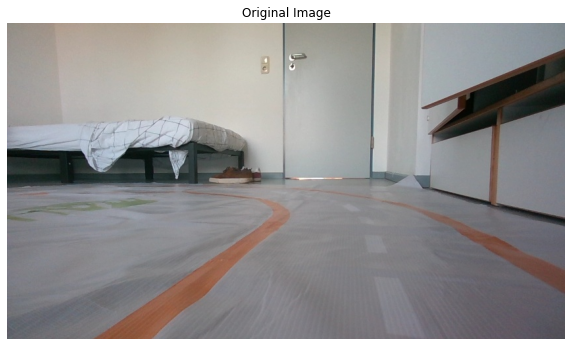

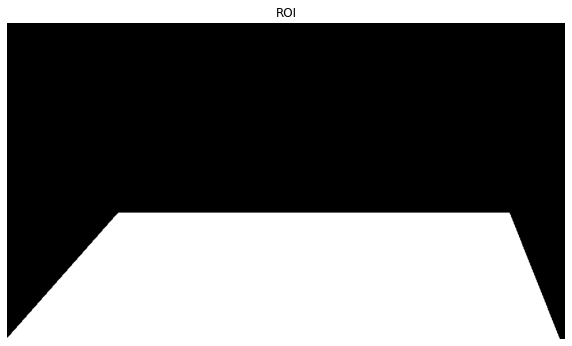

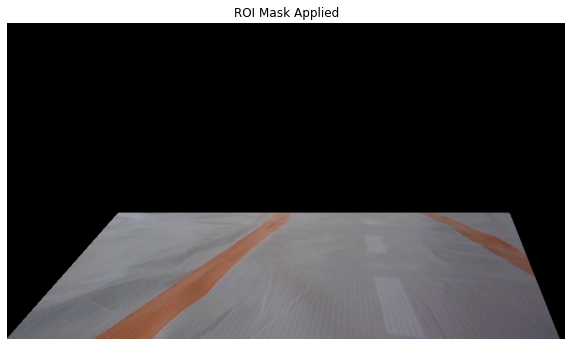

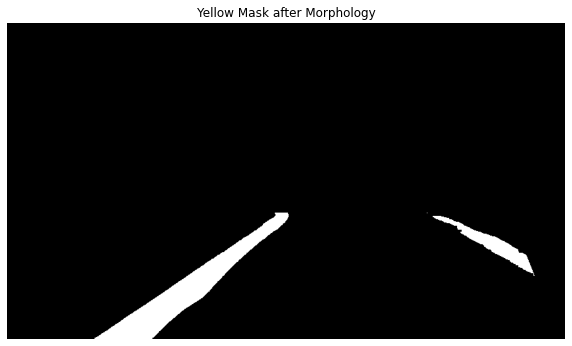

Number of yellow pixels detected in band [369:408]: 2373


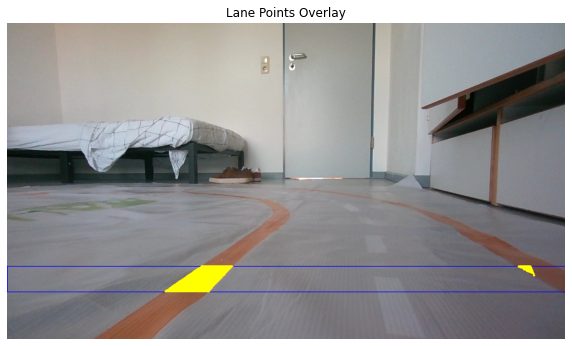

Lane centers found: [(294, 389), (790, 373)]


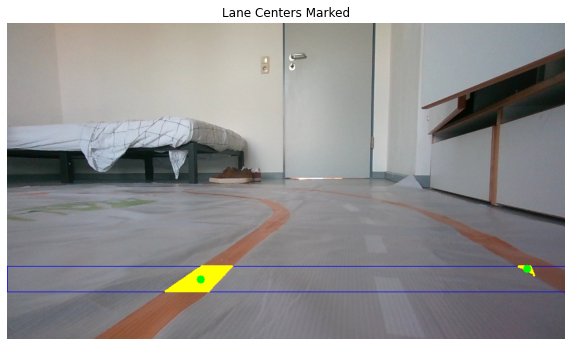

In [37]:
process_image_folder('./images', start_frame=1, end_frame=2, step=4)